In [1]:
from urllib.request import urlopen
from PIL import Image
import timm
import torch
import json
import torchvision

transforms = torchvision.transforms.Compose([
    torchvision.transforms.transforms.Resize(size=256),
    torchvision.transforms.transforms.CenterCrop(size=(224, 224)),
    torchvision.transforms.transforms.ToTensor(),
    torchvision.transforms.transforms.Normalize(mean=torch.Tensor([0.4850, 0.4560, 0.4060]), 
                                                 std=torch.Tensor([0.2290, 0.2240, 0.2250])),
])

# the json file where the output must be stored
json_file = open("imagenet_labels.json", "r")
imagenet_dict = json.load(json_file)
json_file.close()

def predict(model, img):
    output = model(img)
    top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)
    return top5_probabilities, top5_class_indices.tolist()[0]

def preprocess_data(img):
    # unsqueeze single image into batch of 1.
    return transforms(img).unsqueeze(0)

def idx_to_label(idx):
    if isinstance(idx, list):
        return [idx_to_label(i) for i in idx]
    else:
        return imagenet_dict.get(str(idx))

In [47]:
model = timm.create_model('vgg16.tv_in1k', pretrained=True)
model = model.eval()

# get model specific transforms (normalization, resize)
# Is this run on GPU??
#data_config = timm.data.resolve_model_data_config(model)
#transforms = timm.data.create_transform(**data_config, is_training=False)

In [22]:
probs, labels = predict(model, preprocess_data(img))
idx_to_label(labels)

['sports car, sport car',
 'racer, race car, racing car',
 'car wheel',
 'convertible',
 'pickup, pickup truck']

In [48]:
from energy_meter import EnergyMeter
import time

# If we run this twice, the GPU seems to be preprocessing the image when
# we run the CPU test. In order to avoid it, it's necessary to load the
# model again, so it seems something remains in the GPU even after running
# model.to("cpu").

img = Image.open(urlopen(
    'https://unsplash.com/photos/DwxlhTvC16Q/download?ixid=M3wxMjA3fDB8MXxzZWFyY2h8MXx8bWVyY2VkZXMlMjBjYXJ8ZW58MHx8fHwxNjg2NzA1MzUyfDA&force=true&w=640'
))

# CPU
# Disk in LSD15 has an avg i/o speed of 1600MB/s and 
# a power consumption of 6W when active and 1.42W when idle.
meter_cpu = EnergyMeter(disk_avg_speed=1600*1e6, 
                        disk_active_power=6, 
                        disk_idle_power=1.42, 
                        label="CPU Inference")
model = model.to("cpu")
# BEFORE this line, we should have already started running the bash
# script start_meters.sh.
meter_cpu.begin()
for _ in range(200):
    p_img = preprocess_data(img).to("cpu")
    probs, labels = predict(model, p_img)
meter_cpu.end()

# To ensure samples from GPU power stats are not mixed up.
time.sleep(1)

meter_gpu = EnergyMeter(disk_avg_speed=1600*1e6, 
                        disk_active_power=6, 
                        disk_idle_power=1.42, 
                        label="GPU Inference")
model = model.to("cuda:0")
meter_gpu.begin()
for _ in range(200):
    p_img = preprocess_data(img).to("cuda:0")
    probs, labels = predict(model, p_img)
meter_gpu.end()
# Here we should stop the bash script.

In [49]:
meter_gpu.get_total_jules_per_component("meter_2023-06-21 19:30:14")

{'cpu': array([85.735987]),
 'dram': array([1.542354]),
 'gpu': 177.10050152592,
 'disk': 1.8251629952599997}

In [50]:
# GPU still consumes a lot of power when idle:
# https://forums.developer.nvidia.com/t/idle-power-usage-stuck-at-10-20watts-after-running-an-app/217520/10
meter_cpu.get_total_jules_per_component("meter_2023-06-21 19:30:14")

{'cpu': array([2290.845393]),
 'dram': array([80.183267]),
 'gpu': 448.31709289867507,
 'disk': 28.579632619339996}

In [51]:
448.31709289867507/(meter_cpu.meter.result.duration*1e-6)

22.275000000000006

In [28]:
import datetime

datetime.datetime.fromtimestamp(meter_cpu.meter.result.timestamp), datetime.datetime.fromtimestamp(meter_cpu.meter.result.timestamp + meter_cpu.meter.result.duration*1e-6)

(datetime.datetime(2023, 6, 21, 19, 14, 58, 964521),
 datetime.datetime(2023, 6, 21, 19, 15, 19, 69628))

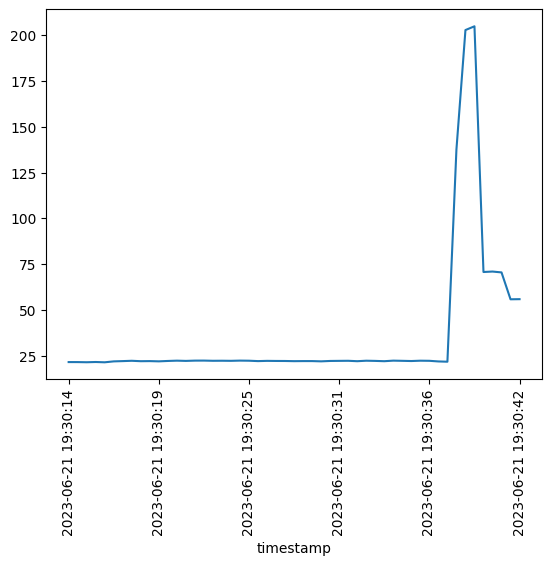

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

pd.read_csv("meter_2023-06-21 19:30:14/gpu_stats.csv", index_col=0)["power_usage(W)"].plot()
plt.xticks(rotation=90)
plt.show()

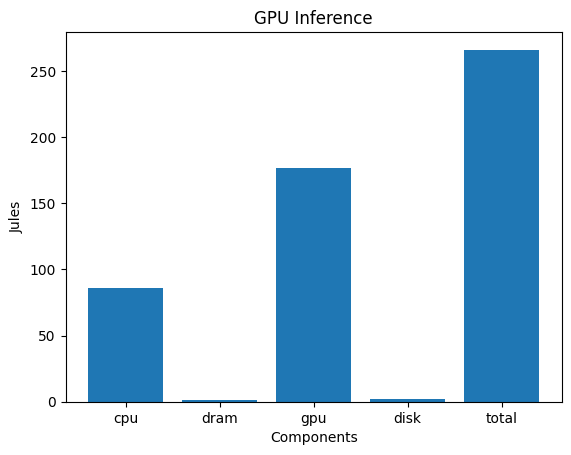

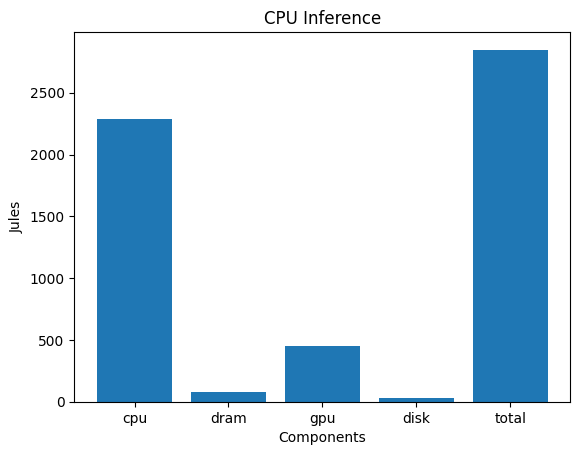

In [54]:
import energy_meter
from importlib import reload
reload(energy_meter)

meter_gpu.plot_total_jules_per_component("meter_2023-06-21 19:30:14")
meter_cpu.plot_total_jules_per_component("meter_2023-06-21 19:30:14")

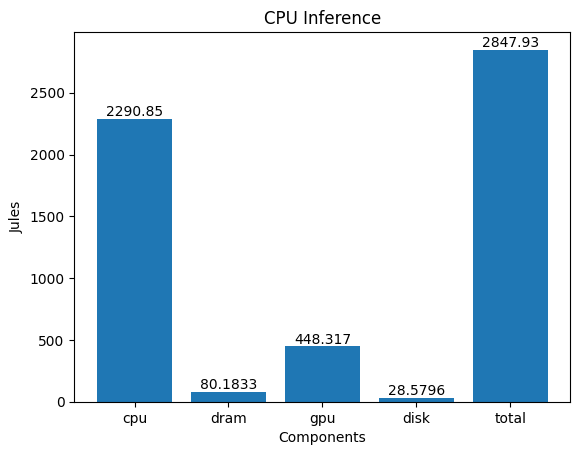

In [69]:
import numpy as np

def plot_total_jules_per_component(self, foldername):
        """This plots the total energy consumption in jules between meter.begin() and meter.end()
        and the total consumption by each component (CPU, DRAM, GPU and disk).
        :param foldername: the path to the folder generated by start_meters.sh.
        """
        data = self.get_total_jules_per_component(foldername)
        data["total"] = np.sum(data.get("cpu")) + np.sum(data.get("dram")) + data.get("disk") + data.get("gpu")
        keys = data.keys()
        values = [float(val) for val in data.values()]

        fig, ax = plt.subplots()
        bars = ax.bar(list(keys), values)
        ax.bar_label(bars)
        plt.xlabel('Components')
        plt.ylabel('Jules')
        plt.title(self.meter.label)
        
        plt.show()

plot_total_jules_per_component(meter_cpu, "meter_2023-06-21 19:30:14")